In [70]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [75]:
prune_in <- '/oak/stanford/groups/mrivas/ukbb24983/array-combined/annotation/ld_indep_20201015/plink_output/ukb24983_cal_hla_cnv.white_british.%s.bool.prune.in'
ldmap_f <- '/scratch/groups/mrivas/ukbb24983/cal/ldmap/ldmap_20201018/ukb24983_cal.white_british.ld_map.0.5r2.tsv.gz'
var_QC_f <-  '/oak/stanford/groups/mrivas/ukbb24983/array-combined/annotation/ld_indep_20201015/ukb24983_cal_hla_cnv.var_QCed.tsv.gz'

# output
redo_list_f <- '/oak/stanford/groups/mrivas/ukbb24983/array-combined/annotation/ld_indep_20201015/plink_output/ukb24983_cal_hla_cnv.white_british.redo.lst'
redo_ld_map_f <- str_replace(redo_list_f, '.redo.lst$', '.redo.ld_map.tsv')

ld_bool_out_f <- file.path(dirname(var_QC_f), 'ukb24983_cal_hla_cnv.white_british.bool.prune.in.tsv')


In [3]:
var_QC_f %>% fread(colClasses = c('#CHROM' = 'character')) %>% 
rename('CHROM'='#CHROM') -> var_QC_df


In [4]:
ldmap_f %>% fread(colClasses = c('#CHR_A' = 'character', 'CHR_B' = 'character')) %>%
rename('CHR_A'='#CHR_A') %>%
filter(SNP_A %in% var_QC_df$ID, SNP_B %in% var_QC_df$ID) -> ldmap_df


In [18]:
'ptv,pav,pcv,utr,intron,others' %>% str_split(',') %>% simplify() %>%
lapply(function(csq){
    sprintf(prune_in, csq) %>%
    fread(head=F) %>%
    rename('ID'=1) %>%
    mutate(Csq = csq)
}) %>% bind_rows() -> prune_in_df


In [80]:
sprintf(prune_in, 'QCed') %>%
fread(head=F) %>%
rename('ID'=1) %>%
left_join(var_QC_df, by='ID') -> prune_in_QCed_df


### count the number of variants (per consequence type)

#### one-phase LD-pruning without using the consequence information

In [81]:
prune_in_QCed_df %>%
count(Csq)

Csq,n
<chr>,<int>
intron,209189
others,195370
pav,61473
pcv,6296
ptv,21924
utr,7497


#### multi-phase LD-pruning with the consequence information

In [46]:
prune_in_df %>% count(Csq)

Csq,n
<chr>,<int>
intron,211902
others,184962
pav,67945
pcv,7545
ptv,22289
utr,9033


### write the results to a file

In [72]:
prune_in_df %>%
rename('#ID' = 'ID') %>%
fwrite(ld_bool_out_f, sep='\t', na = "NA", quote=F)


In [73]:
ld_bool_out_f

[1] "/oak/stanford/groups/mrivas/ukbb24983/array-combined/annotation/ld_indep_20201015/ukb24983_cal_hla_cnv.white_british.bool.prune.in.tsv"

### check whether the LD pruned set are independent

#### (1) The one-phase pruning results

In [95]:
ldmap_df %>% filter(SNP_A %in% (prune_in_QCed_df$ID), SNP_B %in% (prune_in_QCed_df$ID)) %>%
mutate(dist = abs(BP_B - BP_A)) %>%
left_join(prune_in_QCed_df %>% select(ID, Csq) %>% rename('Csq_A' = 'Csq'), by=c('SNP_A'='ID')) %>%
left_join(prune_in_QCed_df %>% select(ID, Csq) %>% rename('Csq_B' = 'Csq'), by=c('SNP_B'='ID')) -> prune_QCed_check_df


In [96]:
prune_QCed_check_df %>% dim()

[1] 286  10

In [97]:
prune_QCed_check_df$dist %>% max()

[1] 920528

In [98]:
prune_QCed_check_df %>% filter(CHR_A != CHR_B) %>% dim()

[1]  0 10

In [99]:
prune_QCed_check_df %>% filter(Csq_A != Csq_B) %>% dim()

[1] 61 10

In [101]:
prune_QCed_check_df %>% count(CHR_A, Csq_A, Csq_B)

CHR_A,Csq_A,Csq_B,n
<chr>,<chr>,<chr>,<int>
2,intron,intron,1
23,intron,intron,88
23,intron,others,15
23,intron,pav,4
23,intron,pcv,3
23,others,intron,15
23,others,others,133
23,others,pav,5
23,others,pcv,1


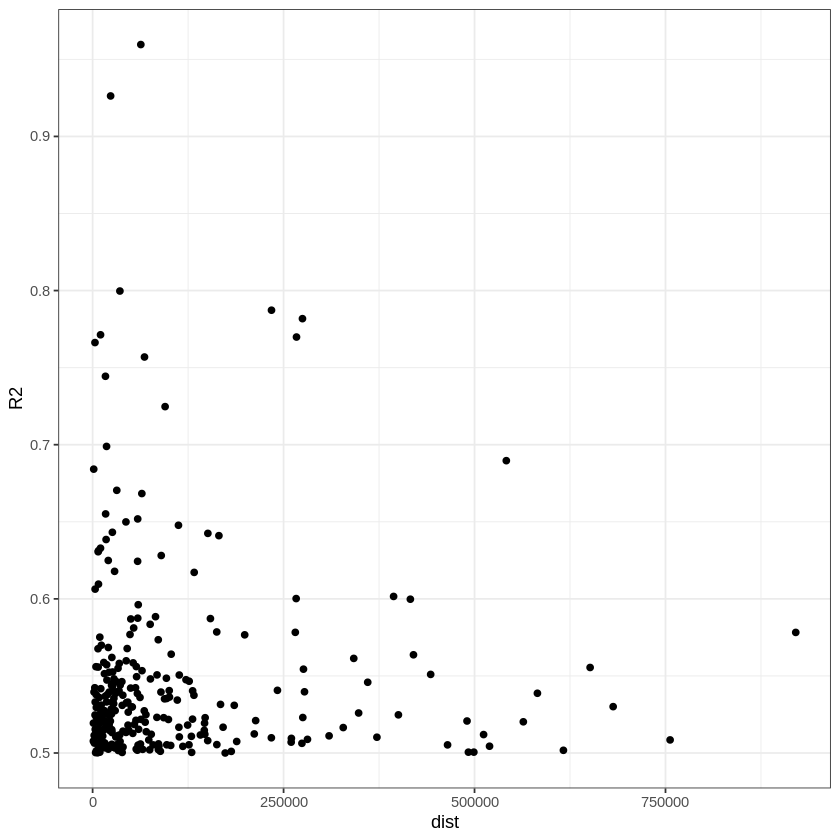

In [102]:
prune_QCed_check_df %>% mutate(dist = abs(BP_B - BP_A)) %>%
ggplot(aes(x = dist, y = R2)) + geom_point() +
theme_bw()

#### (2) the multi-phase pruning results

In [47]:
ldmap_df %>% filter(SNP_A %in% (prune_in_df$ID), SNP_B %in% (prune_in_df$ID)) %>%
mutate(dist = abs(BP_B - BP_A)) %>%
left_join(prune_in_df %>% rename('Csq_A' = 'Csq'), by=c('SNP_A'='ID')) %>%
left_join(prune_in_df %>% rename('Csq_B' = 'Csq'), by=c('SNP_B'='ID')) -> prune_check_df


In [48]:
prune_check_df %>% dim()

[1] 209  10

... it seems like there are 209 pairs with R2>=0.5

In [55]:
prune_check_df$dist %>% max()

[1] 616368

the maximum distance between the markers is 616k 

In [52]:
prune_check_df %>% filter(CHR_A != CHR_B) %>% dim()

[1]  0 10

In [53]:
prune_check_df %>% filter(Csq_A != Csq_B) %>% dim()

[1]  0 10

they were all on the same chromosome (as expected) and have the same consequence type (meaning that our variant filtering script has no issue)

In [54]:
prune_check_df %>% count(CHR_A, Csq_A)

CHR_A,Csq_A,n
<chr>,<chr>,<int>
2,intron,1
23,intron,84
23,others,116
23,pav,6
23,pcv,1
24,others,1


most variant paris were on chrX.

In [57]:
prune_check_df %>% filter(CHR_A != '23')

CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2,dist,Csq_A,Csq_B
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<chr>,<chr>
2,24752171,rs74660091,2,24925731,rs55781300,0.500000,173560,intron,intron
24,13934534,Affx-89015062,24,13989432,rs111882576,0.501807,54898,others,others


there were only 2 the non-chrX variant pairs. They were both R2 ~ 0.5

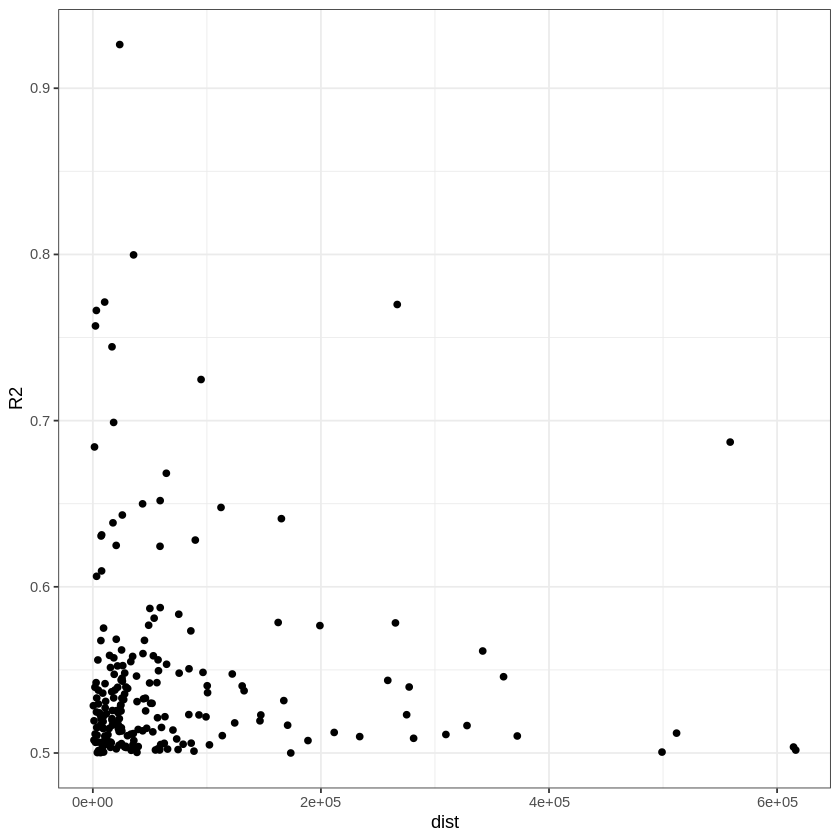

In [58]:
prune_check_df %>% mutate(dist = abs(BP_B - BP_A)) %>%
ggplot(aes(x = dist, y = R2)) + geom_point() +
theme_bw()

### let's write the remaining LD pairs to a file

In [62]:
prune_check_df %>%
rename('#CHR_A' = 'CHR_A') %>%
fwrite(redo_ld_map_f, sep='\t', na = "NA", quote=F)


### Let's write the variants in those LD pairs to a file

In [63]:
c(prune_check_df$SNP_A, prune_check_df$SNP_B) %>% unique() %>% length()

[1] 406

In [67]:
data.frame(
    ID = c(prune_check_df$SNP_A, prune_check_df$SNP_B) %>% unique(),
    stringsAsFactors=F
) %>%
rename('#ID' = 'ID') %>%
fwrite(redo_list_f, sep='\t', na = "NA", quote=F, col.names = F)


In [68]:
redo_list_f

[1] "/oak/stanford/groups/mrivas/ukbb24983/array-combined/annotation/ld_indep_20201015/plink_output/ukb24983_cal_hla_cnv.white_british.redo.lst"

### we appply `plink` again

```
bash 6b_LD_indep.sh redo
```